### Student Information
Name: Gerraldo SC 鄭嘉成

Student ID:　108006218

GitHub ID: Lewisu

Kaggle name: Lewis SC

Kaggle private scoreboard snapshot:
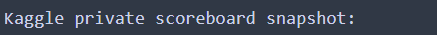


---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2022-Lab2-master Repo](https://github.com/keziatamus/DM2022-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm2022-isa5810-lab2-homework) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/2b0d14a829f340bc88d2660dc602d4bd. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Nov. 22th 11:59 pm, Tuesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 25th 11:59 pm, Friday)__. 

In [42]:
### Begin Assignment Here
import pandas as pd
import seaborn as sns
import nltk
import gensim
import itertools
import warnings
import ssl
import urllib.request
import math

import numpy as np
from numpy import arange

import plotly as py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api

from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax
from keras.callbacks import CSVLogger
%matplotlib inline

In [3]:
### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### ** >>> Exercise 1 (Take home): **  
Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)


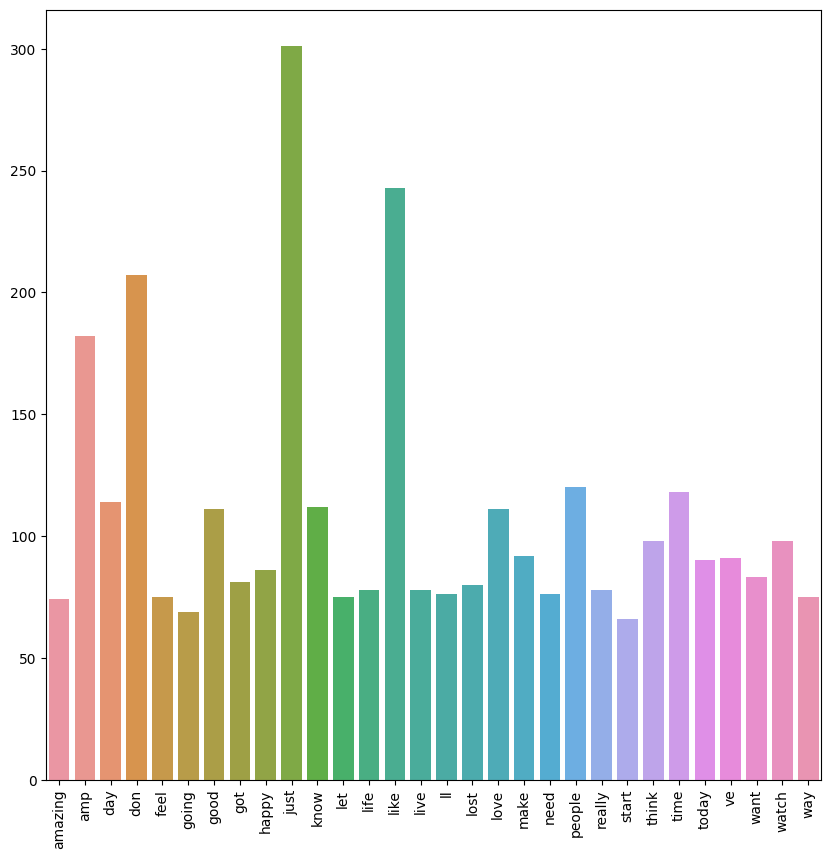

In [4]:
vectorizer = CountVectorizer(max_features = 30, stop_words = "english")
train_counts = vectorizer.fit_transform(train_df["text"])

# First 30 features graph for train dataset
term_frequencies = []
for j in range(0, train_counts.shape[1]):
    term_frequencies.append(sum(train_counts[:,j].toarray()))
    
term_frequencies = np.asarray(train_counts.sum(axis=0))[0]

plt.subplots(figsize=(10, 10))
g = sns.barplot(x=vectorizer.get_feature_names_out(), 
            y=term_frequencies)
g.set_xticklabels(vectorizer.get_feature_names_out(), rotation = 90);

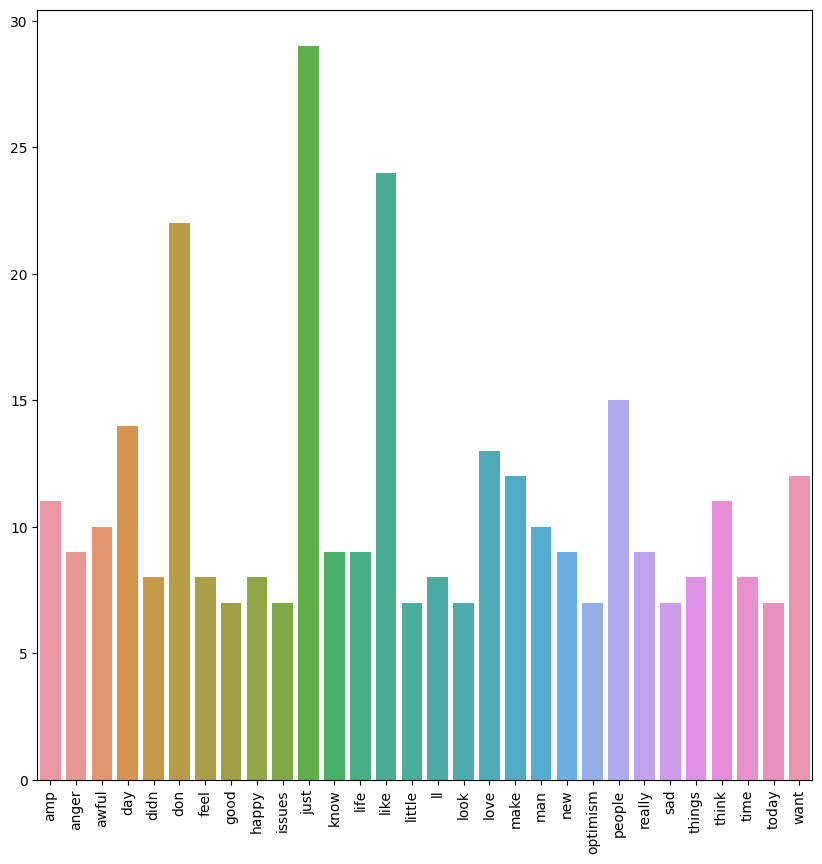

In [5]:
test_counts = vectorizer.fit_transform(test_df["text"])

# First 30 features graph for test dataset
term_frequencies = []
for j in range(0, test_counts.shape[1]):
    term_frequencies.append(sum(test_counts[:,j].toarray()))
    
term_frequencies = np.asarray(test_counts.sum(axis=0))[0]

plt.subplots(figsize=(10, 10))
g = sns.barplot(x=vectorizer.get_feature_names_out(), 
            y=term_frequencies)
g.set_xticklabels(vectorizer.get_feature_names_out(), rotation = 90);

### ** >>> End of Exercise 1**  

In [6]:
## save to pickle file
train_df.to_pickle("train_df.pkl") 
test_df.to_pickle("test_df.pkl")

In [7]:
## load a pickle file
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

In [8]:
# group to find distribution
train_df.groupby(['emotion']).count()['text']

emotion
anger       857
fear       1147
joy         823
sadness     786
Name: text, dtype: int64

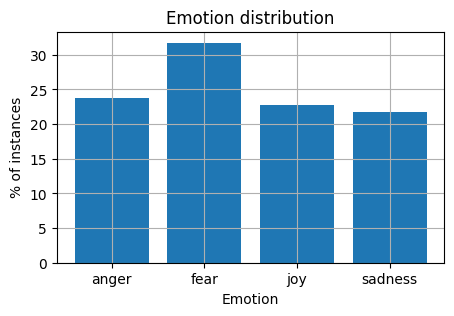

In [9]:
# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

---
### ** >>> Exercise 2 (Take home): **  
Generate an embedding using the TF-IDF vectorizer instead of th BOW one with 1000 features and show the feature names for features [100:110].

In [10]:
# tf idf vectorizer
tfidfvect = TfidfVectorizer(max_features = 1000, stop_words = 'english')
tfidf_counts = tfidfvect.fit_transform(train_df["text"])
# observe some feature names
features_1000 = tfidfvect.get_feature_names_out()
features_1000[100:110]


array(['blue', 'blues', 'body', 'boiling', 'book', 'boss', 'bought',
       'bout', 'boy', 'break'], dtype=object)

### ** >>> End of Exercise 2**  

In [11]:
# for a classificaiton problem, you need to provide both training & testing data
X_train = tfidfvect.transform(train_df['text'])
y_train = train_df['emotion']

X_test = tfidfvect.transform(test_df['text'])
y_test = test_df['emotion']

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3613, 1000)
y_train.shape:  (3613,)
X_test.shape:  (347, 1000)
y_test.shape:  (347,)


In [12]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

## so we get the pred result
y_test_pred[:10]

array(['joy', 'anger', 'fear', 'sadness', 'sadness', 'joy', 'fear', 'joy',
       'fear', 'sadness'], dtype=object)

In [13]:
## accuracy
acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))


training accuracy: 0.98
testing accuracy: 0.77


In [14]:
## precision, recall, f1-score
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

       anger       0.77      0.77      0.77        84
        fear       0.75      0.80      0.77       110
         joy       0.83      0.81      0.82        79
     sadness       0.75      0.69      0.72        74

    accuracy                           0.77       347
   macro avg       0.78      0.77      0.77       347
weighted avg       0.77      0.77      0.77       347



In [15]:
## check by confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

[[65  9  4  6]
 [ 8 88  5  9]
 [ 4  9 64  2]
 [ 7 12  4 51]]


In [16]:
# Function for visualizing confusion_matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

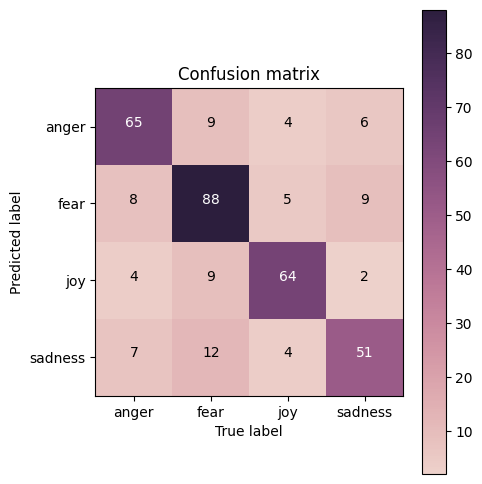

In [17]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

---
### ** >>> Exercise 3 (Take home): **  
Can you interpret the results above? What do they mean?

It creates a table in which we see the predicted label and the supposed label of the data. For example, there's 65 + 9 + 4 + 6 datas are predicted as anger, but only 65 of them are indeed anger, while 9 of them are fear, 4 of them joy, and 6 of them sadness. The same method is used to read the other data.

### ** >>> End of Exercise 3**  

---
### ** >>> Exercise 4 (Take home): **  
Build a model using a ```Naive Bayes``` model and train it. What are the testing results? 

*Reference*: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [21]:
# Naive Bayes Model
model = make_pipeline(tfidfvect, MultinomialNB(alpha = 1))
model.fit(train_df["text"], train_df["emotion"])
label = model.predict(test_df['text'])
model.score(train_df["text"], train_df["emotion"])

0.8923332410738998

In [22]:
## check by confusion matrix
cm = confusion_matrix(y_true=test_df["emotion"], y_pred=label) 
print(cm)

[[61 14  3  6]
 [ 5 94  5  6]
 [ 2  9 65  3]
 [ 1 13  3 57]]


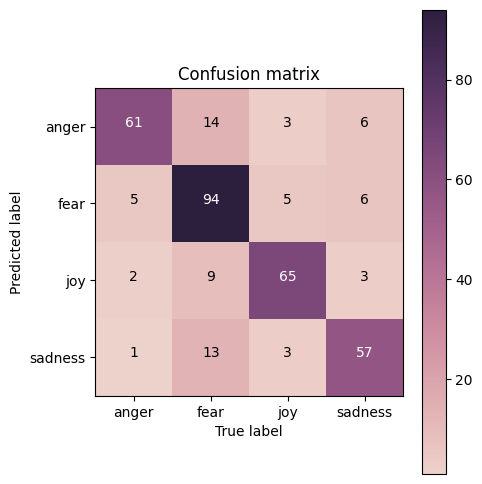

In [23]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

### ** >>> End of Exercise 4**  

---
### ** >>> Exercise 5 (Take home): **  

How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

It seems that DT model have higher result for anger, while NB model have better result for the other emotions. I think this happens because in DT model it branches a lot more to anger because it decides that its features fit the pattern for anger label, and the pattern for anger might have a lot of similarities with other label but the model already decides that it suits anger label more than other label, while actually its not

### ** >>> End of Exercise 5**  

In [27]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

check label:  ['anger' 'fear' 'joy' 'sadness']

## Before convert
y_train[0:4]:
 2738        joy
1849       fear
1578       fear
3092    sadness
Name: emotion, dtype: object

y_train.shape:  (3613,)
y_test.shape:  (347,)


## After convert
y_train[0:4]:
 [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]

y_train.shape:  (3613, 4)
y_test.shape:  (347, 4)


C:\Users\Lewis\AppData\Local\Temp\ipykernel_12260\2157002640.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print('y_train[0:4]:\n', y_train[0:4])


In [28]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

input_shape:  1000
output_shape:  4


In [30]:
# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 64)                64064     
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 re_lu_1 (ReLU)              (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 softmax (Softmax)           (None, 4)                 0     

In [34]:
csv_logger = CSVLogger('logs/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

Epoch 1/25


D:\Anaconda\envs\dmenv\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


113/113 [==============================] - 3s 4ms/step - loss: 1.3181 - accuracy: 0.3626 - val_loss: 1.1440 - val_accuracy: 0.5908
Epoch 2/25
113/113 [==============================] - 0s 2ms/step - loss: 0.6683 - accuracy: 0.8021 - val_loss: 0.5380 - val_accuracy: 0.8127
Epoch 3/25
113/113 [==============================] - 0s 2ms/step - loss: 0.3013 - accuracy: 0.8970 - val_loss: 0.5345 - val_accuracy: 0.8127
Epoch 4/25
113/113 [==============================] - 0s 3ms/step - loss: 0.2050 - accuracy: 0.9322 - val_loss: 0.5750 - val_accuracy: 0.7954
Epoch 5/25
113/113 [==============================] - 0s 2ms/step - loss: 0.1593 - accuracy: 0.9466 - val_loss: 0.6229 - val_accuracy: 0.7925
Epoch 6/25
113/113 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.9529 - val_loss: 0.6660 - val_accuracy: 0.7896
Epoch 7/25
113/113 [==============================] - 0s 2ms/step - loss: 0.1141 - accuracy: 0.9552 - val_loss: 0.7220 - val_accuracy: 0.7695
Epoch 8/25
113/11

In [35]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

3/3 [==============================] - 0s 2ms/step


array([[2.2888562e-05, 1.1722508e-05, 9.9952924e-01, 4.3622221e-04],
       [9.9999452e-01, 7.0029233e-07, 9.9162389e-07, 3.8498861e-06],
       [1.3637140e-02, 9.8382521e-01, 1.3485489e-03, 1.1891167e-03],
       [1.1830094e-05, 4.7804287e-01, 6.7196321e-05, 5.2187818e-01],
       [3.4888522e-04, 9.4912887e-01, 9.5073221e-05, 5.0427109e-02]],
      dtype=float32)

In [36]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

array(['joy', 'anger', 'fear', 'sadness', 'fear'], dtype=object)

In [38]:
print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

testing accuracy: 0.76


In [39]:
#Let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("logs/training_log.csv")
training_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.362580,1.318098,0.590778,1.143957
1,1,0.802104,0.668315,0.812680,0.537985
2,2,0.897038,0.301346,0.812680,0.534459
3,3,0.932189,0.204970,0.795389,0.575014
4,4,0.946582,0.159264,0.792507,0.622874
5,5,0.952948,0.132357,0.789625,0.665989
6,6,0.955162,0.114143,0.769452,0.721971
7,7,0.961251,0.099735,0.775216,0.764389
8,8,0.962912,0.091403,0.780980,0.809570
9,9,0.962912,0.086081,0.772334,0.838491


---
### ** >>> Exercise 6 (Take home): **  

Plot the Training and Validation Accuracy and Loss (different plots). How to interpret the graphs you got? How are they related to the concept of overfitting/underfitting covered in class?

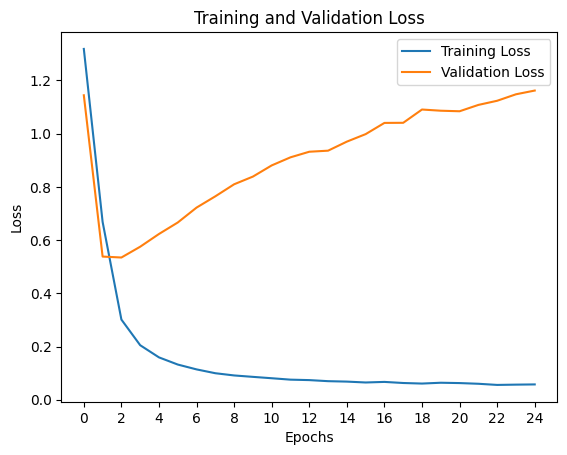

In [43]:
# Generate a sequence of integers to represent the epoch numbers
ranges = range(0, epochs)
 
# Plot and label the training and validation loss values
plt.plot(ranges, training_log.loss, label='Training Loss')
plt.plot(ranges, training_log.val_loss, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, epochs, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

The result of the plot shows that our model is overfitted. Since the validation loss is way higher than training loss.

### ** >>> End of Exercise 6**  

In [44]:
warnings.filterwarnings('ignore')
# # if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

,id,text,text_tokenized
2738,30734,When your rewatching glee and break down in te...,"[When, your, rewatching, glee, and, break, dow..."
1849,20992,@darwinwatersons @pennyfitzger31 @gumballwatte...,"[@, darwinwatersons, @, pennyfitzger31, @, gum..."
1578,20721,@rkuuleiq Fear is best/beast product of God/s....,"[@, rkuuleiq, Fear, is, best/beast, product, o..."
3092,40265,she's always so insensitive whenever i grieve ...,"[she, 's, always, so, insensitive, whenever, i..."
1971,21114,It's so funny cause Cooper's going to go farth...,"[It, 's, so, funny, cause, Cooper, 's, going, ..."


In [45]:
## create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

array([list(['When', 'your', 'rewatching', 'glee', 'and', 'break', 'down', 'in', 'tears', 'all', 'over', 'again', '.', '😭😢']),
       list(['@', 'darwinwatersons', '@', 'pennyfitzger31', '@', 'gumballwatter15', 'ok', 'but', 'why', 'tomorrow', 'a', 'horrible', 'day', ',', 'my', 'day', 'was', 'great', '!']),
       list(['@', 'rkuuleiq', 'Fear', 'is', 'best/beast', 'product', 'of', 'God/s', '.', ':', ')', '#', 'aTheism', '#', 'theism', '#', 'biBle', '#', 'afraid', '#', 'christianity', '#', 'hell', '#', 'heaven', '#', 'purgatory', '#', 'psychology', '#', 'jesus'])],
      dtype=object)

In [46]:
## setting
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20

## model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_epochs)